<a href="https://colab.research.google.com/github/dfavenfre/RAG-Optimization/blob/main/src/notebook/RAG_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages-to-Install

In [ ]:
!pip install psutil gputil langchain_community tiktoken langchain-openai langchainhub langchain pypdf unstructured==0.6.1 faiss-gpu lark langchain-cohere langchain-huggingface transformers bitsandbytes accelerate torch sentence_transformers umap-learn scikit-learn --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

## Imports

In [ ]:
# langchain
from langchain_community.document_loaders import (WebBaseLoader,PyPDFLoader,UnstructuredPDFLoader,UnstructuredFileLoader)
from langchain_core.output_parsers import (StrOutputParser, PydanticOutputParser)
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.prompts import (ChatPromptTemplate, PromptTemplate,FewShotChatMessagePromptTemplate)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.document_loaders import DirectoryLoader
from langchain_core.tracers.context import tracing_v2_enabled
from langchain.vectorstores import (Chroma, FAISS, Pinecone)
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import (ChatOpenAI, OpenAIEmbeddings)
from langchain.retrievers import ParentDocumentRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_cohere import CohereEmbeddings
from langchain_huggingface import HuggingFacePipeline
from langchain.storage import InMemoryStore
from langchain.load import dumps, loads
from langchain import hub

# transformers
from transformers import (pipeline,AutoModelForCausalLM,AutoTokenizer,BitsAndBytesConfig)

# openai
from openai import OpenAI

# scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Cohere
import cohere

# basics
from typing import Optional, Tuple, Dict, Union, List, Callable
from itertools import product
from pydantic import BaseModel, Field
import matplotlib.pyplot as plt
from datetime import datetime
from operator import itemgetter
from google.colab import userdata
import plotly.express as px
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import tiktoken
import time
import psutil
import GPUtil
import asyncio
import umap
import json
import bs4
import os

## .env

In [ ]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ["LANGCHAIN_API_KEY"] = "<ADD_YOUR_OWN_API>"
os.environ["HUGGING_FACE_HUB_TOKEN"] = "<ADD_YOUR_OWN_API>"
os.environ["HF_TOKEN"] = "<ADD_YOUR_OWN_API>"

# Models & Prompts

## Prompts

## System Prompts

In [ ]:
chunk_summarizer_prompt = """
1 - Your task is to find topic keywords based on what the given piece of context is about
Context: {context}
Output format instructions: {output_format}
"""

raw_raq_prompt = """
1 - Your task is to answer the following question based on the context you are given
Context:\n{context}
Now answer this question:\n{question}
"""

raw_multi_query_prompt = """
1 - Your task is to generate four different versions of the given user question in
Turkish to retrieve relevant documents from a vector database.

2 - By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.

3 - Provide these alternative questions separated by newlines.
Original question: {question}
"""

raw_query_decomposition_prompt = """
You are a helpful assistant that generates multiple sub-questions related to an input question in Turkish. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):
"""

raw_recursive_query_answering_prompt = """
Here is the question you need to answer:
\n --- \n {question} \n --- \n
Here is any available background question + answer pairs:
\n --- \n {q_a_pairs} \n --- \n
Here is additional context relevant to the question:
\n --- \n {context} \n --- \n
Use the above context and any background question + answer pairs to answer the question:\n{question}
"""

raw_query_stepdown_prompt = """
You are an insurance assistant for Sigortam.net insurance company.
I am going to ask you a question and your response should be comprehensive
and not contradicted with the following context if they are relevant.

Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:

"""

raw_rag_fusion_prompt = """
You are a helpful assistant that generates multiple
search queries based on a single input query.\n
Generate multiple search queries in Turkish related to: {question} \n
Output (4 queries):
"""

## Few-shot examples

In [ ]:
examples = [
    {
        "input": "Fiyat bilgisi alabilir miyim?",
        "output": "Sigorta poliçeleri ile ilgili fiyat bilgisi alabilir miyim?",
    },
    {
        "input": "Kedime sağlık sigorta yaptırmak istiyorum",
        "output": "Hayvanlar için sağlık sigortası satın almak istiyorum",
    },
    {
        "input":"evimin depremden korunup korunmadığını nasıl anlarım?",
        "output": "Deprem sigortasına nasıl başvurabilirim?"
    }
]

In [ ]:
rag_prompt = PromptTemplate.from_template(raw_raq_prompt)
multi_query_prompt = PromptTemplate.from_template(raw_multi_query_prompt)
query_decomposition_prompt = PromptTemplate.from_template(raw_query_decomposition_prompt)
recursive_query_answering_prompt = PromptTemplate.from_template(raw_recursive_query_answering_prompt)
stepdown_system_prompt = ChatPromptTemplate.from_template(raw_query_stepdown_prompt)
rag_fusion_system_prompt = ChatPromptTemplate.from_template(raw_rag_fusion_prompt)
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

stepdown_fs_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are an insurance assistant for Sigortam.net insurance company.
            Your task is to paraphrase a question to a more specific step-down
            question in Turkish, which is easier to answer.

            Here are a few examples:
            """,
        ),
        few_shot_prompt,
        ("user", "{question}"),
    ]
)

## Models

### LLMs

In [ ]:
openai_turbo = ChatOpenAI(
    openai_api_key=userdata.get("openai_trustguard"),
    temperature=1e-10,
    max_tokens=1000,
    model_name="gpt-3.5-turbo"
)

evaluator = ChatOpenAI(
    openai_api_key=userdata.get("openai_trustguard"),
    temperature=1e-10,
    max_tokens=1000,
    model_name="gpt-4o"
)

client = OpenAI(api_key=userdata.get("openai_trustguard"))
cohere_client = cohere.Client(api_key=userdata.get("cohere"))

### Embedding Models

In [ ]:
bge_m3 = HuggingFaceBgeEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

ada_002 = OpenAIEmbeddings(
    openai_api_key=userdata.get("openai_trustguard"),
)

cohere_embedding = CohereEmbeddings(
    cohere_api_key=userdata.get("cohere"),
    model="embed-multilingual-v3.0"
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

# Helper Functions

In [ ]:
class TopicIdentifier(BaseModel):
  keywords: List[str] = Field(
      description="Identify the topics based on the question titles in the given context and put all topics in a list"
      )

class IdentifyQuestionTopic(BaseModel):
  keywords: str = Field(
      description="Identify the topic as a keyword based on the question in the given context."
      )

def chunk_up_documents(
    file_path: str,
    chunk_size: Optional[int] = 1000,
    chunk_overlap: Optional[int] = 100
    ):
  documents = []
  for file in os.listdir(file_path):
      if file.endswith(".pdf"):
          pdf_path = file_path + file
          loader = PyPDFLoader(pdf_path)
          documents.extend(loader.load())

  text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
      separators="\n\n",
      chunk_size=chunk_size,
      chunk_overlap=chunk_overlap
  )
  chunked_docs = text_splitter.split_documents(documents)
  return chunked_docs

def format_documents(docs: List[str]) -> str:
  return "\n\n".join(doc.page_content for doc in docs)

def get_openai_embedding(text, model="text-embedding-ada-002"):
  return client.embeddings.create(input = [text], model=model).data[0].embedding

def get_cohere_embeddings(text):
  response = cohere_client.embed(texts=[text])
  embedding = response.embeddings[0]
  return embedding

def get_bge_embeddings(text):
  embeddings = bge_m3.embed_query(text)
  return embeddings

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]

def format_qa_pair(question, answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()


def filter_embeddings(
     search_object,
     embedding_model,
     s_threshold: Optional[int] = 0.7,
     r_threshold: Optional[int] = 0.7
     ):
  relevancy_filter = EmbeddingsFilter(
      embeddings=embedding_model,
      s_threshold=s_threshold
      )
  redundant_filter = EmbeddingsRedundantFilter(
       embeddings=embedding_model,
       r_threshold=r_threshold
       )
  pipeline_compressor = DocumentCompressorPipeline(
      transformers=[redundant_filter, relevancy_filter]
      )
  compression_retriever = ContextualCompressionRetriever(
      base_compressor=pipeline_compressor,
      base_retriever=search_object.as_retriever()
      )

  return compression_retriever


def measure_resource_usage(function: Callable, **parameters):
   start_time = time.time()
   cpu_before = psutil.cpu_percent(interval=5)
   ram_before = psutil.virtual_memory().percent

   query_result = function(**parameters)
   time.sleep(2)

   cpu_after = psutil.cpu_percent(interval=5)
   ram_after = psutil.virtual_memory().percent
   end_time = time.time()
   runtime = np.abs(end_time - start_time)

   cpu_usage_percentage = np.abs(round(cpu_after,4) - round(cpu_before,4))
   ram_usage_percentage = np.abs(round(ram_after,4) - round(ram_before,4))

   return runtime, cpu_usage_percentage, ram_usage_percentage, query_result


def apply_reciprocal_ranking(results: list[list], k=60):
    """
    Reciprocal_rank_fusion that takes multiple lists of ranked documents
    and an optional parameter k used in the RRF formula.
    """

    fused_scores = {}
    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results[:4]


def combine_embeddings(
    query: str,
    vector_store: FAISS,
    embedding_model: Union['OpenAIEmbeddings', 'CohereEmbeddings', 'HuggingFaceBgeEmbeddings'],
    number_of_documents: Optional[int] = 4,
    calculate_similarity: Optional[bool] = True
    ) -> Union[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray, List[float]]]:

    similarity_scores: List[np.ndarray] = []
    sanitized_document_content: List[str] = []

    query_embedding = embedding_model.embed_query(query)
    rag_embeddings = vector_store.similarity_search(query, k=number_of_documents)

    for doc in rag_embeddings:
      sanitized_document_content.append(doc.page_content)

    rag_vector_embeddings = embedding_model.embed_documents(sanitized_document_content)

    for doc_embedding in rag_vector_embeddings:
      similarity_scores.append(cosine_similarity([query_embedding], [doc_embedding])[0][0])

    if calculate_similarity:
      return query_embedding, rag_vector_embeddings, similarity_scores

    return query_embedding, rag_vector_embeddings

def plotly_plot_2d_embeddings(embeddings_2d, method_name, labels, similarity_scores=None):
    if similarity_scores:
        hover_text = ['Query'] + [f'Similarity: {score:.2f}' for score in similarity_scores]
    else:
        hover_text = labels

    fig = px.scatter(
        x=embeddings_2d[:, 0],
        y=embeddings_2d[:, 1],
        color=labels,
        title=f'{method_name} 2D Visualization of Query and Retrieved Embeddings',
        labels={'color': 'Embeddings'},
        hover_name=hover_text
    )
    fig.show()

def visualize_embeddings(query_embedding: np.ndarray, retrieved_embeddings: np.ndarray, similarity_scores: List[float]):
    all_embeddings = np.vstack([query_embedding, retrieved_embeddings])
    tsne = TSNE(n_components=2, perplexity=min(len(retrieved_embeddings) - 1, 30), random_state=42)
    all_embeddings_2d_tsne = tsne.fit_transform(all_embeddings)
    labels = ['Query'] + ['Vector'] * len(retrieved_embeddings)
    plotly_plot_2d_embeddings(all_embeddings_2d_tsne, 't-SNE', labels, similarity_scores)


def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height:.5f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom')

# Tools

In [ ]:
def chunk_summarizer(
    raw_prompt: str,
    chunk_context: str,
    llm: Optional[Union[ChatOpenAI, HuggingFacePipeline, pipeline]] = openai_turbo
    ) -> str:

    "Summarizes text context and returns a list of keywords based on the given context"

    topic_parser = PydanticOutputParser(pydantic_object=TopicIdentifier)
    system_prompt = PromptTemplate(
        template=raw_prompt,
        input_variables=["context"],
        partial_variables={"output_format":topic_parser.get_format_instructions()}
    )

    summarize_chain = (
        {
            "context": itemgetter("context")
        }
        | system_prompt
        | llm
        | topic_parser
    )

    return summarize_chain.invoke({"context": chunk_context})

# Metadata Optimization

In [ ]:
document_chunks = chunk_up_documents(
    file_path="/content/rag_documents/",
    chunk_size=2000,
    chunk_overlap=0
)
print(len(document_chunks))

63


In [ ]:
error_count = 0
for chunk in document_chunks:
  empty_chunks = []
  try:
    output = chunk_summarizer(chunk_summarizer_prompt, chunk)
    chunk.metadata["keywords"] = output.keywords
  except Exception as _:
    error_count += 1
    print(error_count)
    empty_chunks.append(chunk)

# Validation Data

In [ ]:
validation_data = pd.read_excel("/content/trustguard_reference_data.xlsx")
question_count = 0
for question in validation_data.iterrows():
  question_count += 1
  print(f"{question_count} - {question[1]['question']}")
validation_data.tail()

1 - Ferdi Kaza Sigortası ve Hayat Sigortası Farkı Nedir?
2 - Konut Sigortasını Kimler Yaptırabilir?
3 - Konut Sigortası ile DASK Arasındaki Farklar Neler?
4 - Trafik Sigortasında Araç Başına Maddi Hasar Nedir?
5 - Zorunlu Trafik Sigortası Kazada Ne Kadar Öder?
6 - Evcil Hayvan Sigortası Avantajlı Ek Teminatları Nelerdir?
7 - Evcil Hayvan Sigortası Yapan Şirketler Hangileridir?
8 - Özel Sağlık Sigortası Nasıl Yaptırılır?
9 - Özel Sağlık Sigortasında Hangi Hastalıklar İçin Bekleme Süresi Vardır?
10 - Trafik Sigortası Yaptırmamanın Cezası Nedir?


,question,reference_answer
5,Evcil Hayvan Sigortası Avantajlı Ek Teminatlar...,Ek prim ödenerek avantajlı ek teminatlarla da ...
6,Evcil Hayvan Sigortası Yapan Şirketler Hangile...,Evcil hayvan sigortası yapan birçok sigorta şi...
7,Özel Sağlık Sigortası Nasıl Yaptırılır?,"Özel sağlık sigortası yaptırmak istiyorum, ne ..."
8,Özel Sağlık Sigortasında Hangi Hastalıklar İçi...,Özel sağlık sigortanı yaptırdıktan sonra bazı ...
9,Trafik Sigortası Yaptırmamanın Cezası Nedir?,Trafik sigortası yaptırmadan trafiğe çıkmak ke...


# Vectorstores with Different Embedding Functions

* BGE Multilingual
* Cohere Multilingual
* OpenAI EN

## Cohere Embeddings

In [ ]:
faissdb_cohere = await FAISS.afrom_documents(document_chunks, cohere_embedding)
faissdb_cohere.save_local("faiss_cohere_nometadata")

## BGE Embeddings

In [ ]:
faissdb_bge = await FAISS.afrom_documents(document_chunks, bge_m3)
faissdb_bge.save_local("faiss_bge_nometadata")

## OpenAI Embeddings

In [ ]:
faissdb_openai = await FAISS.afrom_documents(document_chunks, ada_002)
faissdb_openai.save_local("faiss_openai_nometadata")

## Vectorstore with Metadata

In [ ]:
loaded_faissdb_bge = FAISS.load_local(
    folder_path="./faiss_bge",
    embeddings=bge_m3,
    allow_dangerous_deserialization=True
    )

loaded_faissdb_cohere = FAISS.load_local(
    folder_path="./faiss_cohere",
    embeddings=cohere_embedding,
    allow_dangerous_deserialization=True
    )

loaded_faissdb_openai = FAISS.load_local(
    folder_path="./faiss_openai",
    embeddings=ada_002,
    allow_dangerous_deserialization=True
    )

## Without Metadata

In [ ]:
loaded_faissdb_bge_nm = FAISS.load_local(
    folder_path="./faiss_bge_nometadata",
    embeddings=bge_m3,
    allow_dangerous_deserialization=True
    )

loaded_faissdb_cohere_nm = FAISS.load_local(
    folder_path="./faiss_cohere_nometadata",
    embeddings=cohere_embedding,
    allow_dangerous_deserialization=True
    )

loaded_faissdb_openai_nm = FAISS.load_local(
    folder_path="./faiss_openai_nometadata",
    embeddings=ada_002,
    allow_dangerous_deserialization=True
    )

# RAG Methods

* Stuff Method
* Contextual Compression
* Multi-query
* Query translation (Decomposition)
* Reciphorical RAG
* RAPTOR


## Stuff Method



In [ ]:
def stuff_method(
    retriever_object,
    question,
    llm: Optional[Union[ChatOpenAI, HuggingFacePipeline, pipeline]] = openai_turbo
    ):
  stuff_chain = (
      {
          "context": itemgetter("question")
          | retriever_object.as_retriever()
          | format_documents,
          "question": itemgetter("question")
      }
      | rag_prompt
      | llm
      | StrOutputParser()
  )
  return stuff_chain.invoke({"question": question})

In [ ]:
stuff_rag_chain = (
    {
        "context": itemgetter("question")
        | loaded_faissdb_bge.as_retriever()
        | format_documents,
        "question": itemgetter("question")
    }
    | rag_prompt
    | openai_turbo
    | StrOutputParser()
)

In [ ]:
embeddings = {
    loaded_faissdb_bge: "bge_m3",
    loaded_faissdb_cohere: "cohere_embedding",
    loaded_faissdb_openai: "ada_002"
}
vectorstores = [loaded_faissdb_bge, loaded_faissdb_cohere, loaded_faissdb_openai]

for vs in vectorstores:
  print(embeddings[vs])

bge_m3
cohere_embedding
ada_002


In [ ]:
vectorstores = [loaded_faissdb_bge, loaded_faissdb_cohere, loaded_faissdb_openai]
embeddings = {loaded_faissdb_bge: "bge_m3", loaded_faissdb_cohere: "cohere_embedding",loaded_faissdb_openai: "ada_002"}
stuff_method_results = {"run_time": [],"embedding_model": [],"similarity_score": []}

for question, vectorstore in product(validation_data["question"], vectorstores):
  process_begins = time.time()
  llm_response = stuff_method(vectorstore, question)
  process_ends = time.time()
  run_time = process_ends - process_begins
  if vectorstore == loaded_faissdb_bge:
    llm_embedding = get_bge_embeddings(llm_response)
    query_embedding = get_bge_embeddings(question)
    similarity_score = cosine_similarity([llm_embedding], [query_embedding])[0][0]
    print(similarity_score)

  elif vectorstore == loaded_faissdb_cohere:
    llm_embedding = get_cohere_embeddings(llm_response)
    query_embedding = get_cohere_embeddings(question)
    similarity_score = cosine_similarity([llm_embedding], [query_embedding])[0][0]
    print(similarity_score)

  else:
    llm_embedding = get_openai_embedding(llm_response)
    query_embedding = get_openai_embedding(question)
    similarity_score = cosine_similarity([llm_embedding], [query_embedding])[0][0]
    print(similarity_score)

  stuff_method_results["run_time"].append(round(run_time, 3))
  stuff_method_results["similarity_score"].append(similarity_score)
  stuff_method_results["embedding_model"].append(embeddings[vectorstore])

  print(stuff_method_results)

In [ ]:
df = pd.DataFrame.from_dict(stuff_method_results)
df.to_csv("stuff_method_results.csv")

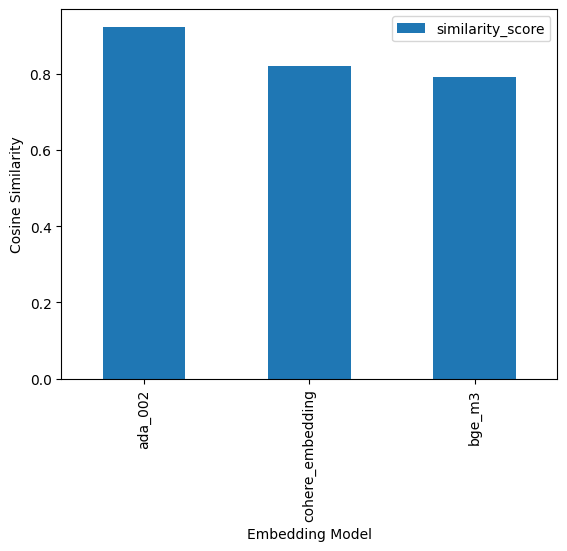

In [ ]:
df.groupby("embedding_model")[["similarity_score"]].mean().sort_values(by="similarity_score", ascending=False).plot(kind="bar");plt.ylabel("Cosine Similarity");plt.xlabel("Embedding Model");

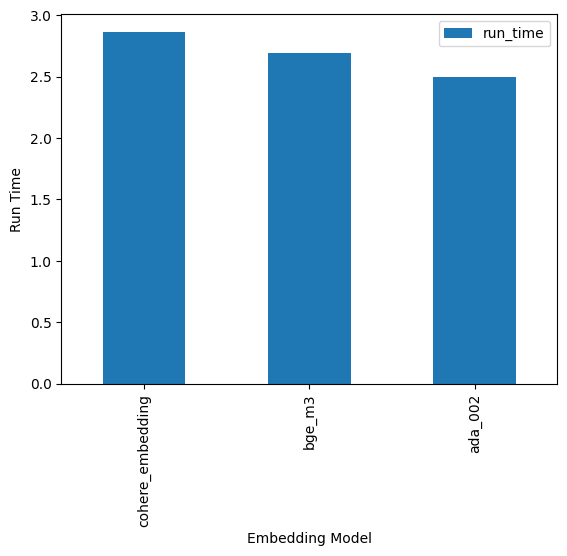

In [ ]:
df.groupby("embedding_model")[["run_time"]].mean().sort_values(by="run_time", ascending=False).plot(kind="bar");plt.ylabel("Run Time");plt.xlabel("Embedding Model");

## Contextual Compression

In [ ]:
def contextual_compression(
    retriever_object,
    embedding_funtion,
    question,
    llm: Optional[Union[ChatOpenAI, HuggingFacePipeline, pipeline]] = openai_turbo
    ):
  compression_retriever = filter_embeddings(
      retriever_object,
      embedding_funtion
  )
  contextual_compression_chain = (
    {
        "context": itemgetter("question")
        | compression_retriever
        | format_documents,
        "question": itemgetter("question")
        }
    | rag_prompt
    | llm
    | StrOutputParser()

    )

  return contextual_compression_chain.invoke({"question": question})

In [ ]:
compression_retriever = filter_embeddings(
    loaded_faissdb_bge,
    bge_m3,
    0.7,
    0.7
)
contextual_compression_chain = (
  {
      "context": itemgetter("question")
      | compression_retriever
      | format_documents,
      "question": itemgetter("question")
      }
  | rag_prompt
  | openai_turbo
  | StrOutputParser()
  )

In [ ]:
vectorstores = [loaded_faissdb_bge, loaded_faissdb_cohere, loaded_faissdb_openai]
embeddings = {loaded_faissdb_bge: "bge_m3", loaded_faissdb_cohere: "cohere_embedding",loaded_faissdb_openai: "ada_002"}
embedding_models = [bge_m3, cohere_embedding, ada_002]
contextual_compression_results = {"run_time": [],"embedding_model": [],"similarity_score": []}

for question, vectorstore in product(validation_data["question"], vectorstores):
  if vectorstore == loaded_faissdb_bge:
    process_begins = time.time()
    llm_response = contextual_compression(vectorstore, bge_m3, question,)
    process_ends = time.time()
    run_time = process_ends - process_begins

    llm_embedding = get_bge_embeddings(llm_response)
    query_embedding = get_bge_embeddings(question)
    similarity_score = cosine_similarity([llm_embedding], [query_embedding])[0][0]

  elif vectorstore == loaded_faissdb_cohere:
    process_begins = time.time()
    llm_response = contextual_compression(vectorstore, cohere_embedding, question,)
    process_ends = time.time()
    run_time = process_ends - process_begins
    llm_embedding = get_cohere_embeddings(llm_response)
    query_embedding = get_cohere_embeddings(question)
    similarity_score = cosine_similarity([llm_embedding], [query_embedding])[0][0]

  else:
    process_begins = time.time()
    llm_response = contextual_compression(vectorstore, ada_002, question,)
    process_ends = time.time()
    run_time = process_ends - process_begins
    llm_embedding = get_openai_embedding(llm_response)
    query_embedding = get_openai_embedding(question)
    similarity_score = cosine_similarity([llm_embedding], [query_embedding])[0][0]

  contextual_compression_results["run_time"].append(round(run_time, 3))
  contextual_compression_results["similarity_score"].append(similarity_score)
  contextual_compression_results["embedding_model"].append(embeddings[vectorstore])


In [ ]:
cc_df = pd.DataFrame.from_dict(contextual_compression_results)
cc_df.to_csv("contextual_compression_results.csv")


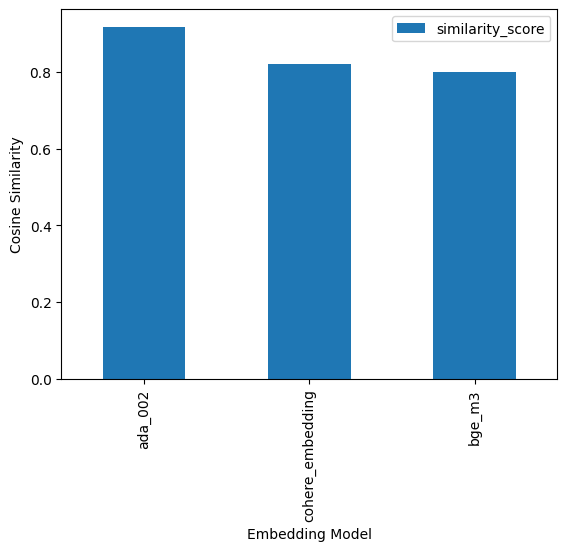

In [ ]:
cc_df.groupby("embedding_model")[["similarity_score"]].mean().sort_values(by="similarity_score", ascending=False).plot(kind="bar");plt.ylabel("Cosine Similarity");plt.xlabel("Embedding Model");

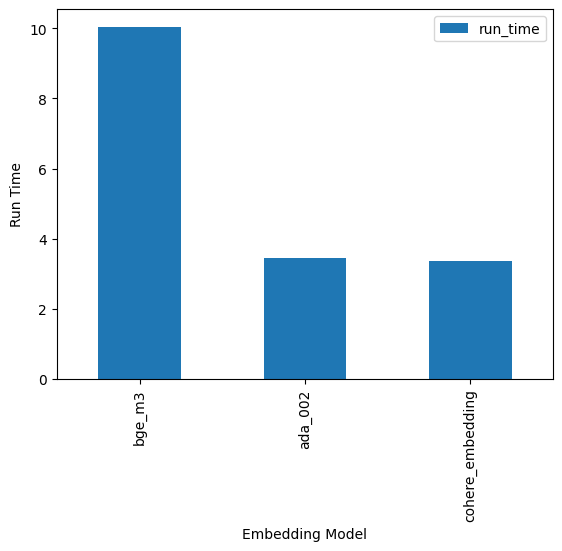

In [ ]:
cc_df.groupby("embedding_model")[["run_time"]].mean().sort_values(by="run_time", ascending=False).plot(kind="bar");plt.ylabel("Run Time");plt.xlabel("Embedding Model");

## Multi-Query

In [ ]:
def multi_query(
    question: str,
    retriever_object
    ):
  multi_query_generator = (
      multi_query_prompt
      | openai_turbo
      | StrOutputParser()
      | (lambda x: x.split("\n"))
      )

  doc_retriever_chain = (
      multi_query_generator
      | retriever_object.as_retriever().map()
      | get_unique_union
      )

  rag_chain = (
      {
          "context": doc_retriever_chain,
          "question": itemgetter("question")
      }
      | rag_prompt
      | openai_turbo
      | StrOutputParser()
      )

  return rag_chain.invoke({"question":question})


In [ ]:
multi_query_generator = (
    multi_query_prompt
    | openai_turbo
    | StrOutputParser()
    | (lambda x: x.split("\n"))
    )

doc_retriever_chain = (
    multi_query_generator
    | loaded_faissdb_bge.as_retriever().map()
    | get_unique_union
    )

multi_query_rag_chain = (
    {
        "context": doc_retriever_chain,
        "question": itemgetter("question")
    }
    | rag_prompt
    | openai_turbo
    | StrOutputParser()
    )

## Query Decomposition

In [ ]:
def query_decomposition(
    question: str,
    retriever_object: FAISS
    ):

  query_decomposition_generator = (
      {
          "question": itemgetter("question")
      }
      | query_decomposition_prompt
      | openai_turbo
      | StrOutputParser()
      | (lambda x: x.split("\n"))

      )

  q_a_pairs = ""
  answer_list = []
  for q in query_decomposition_generator.invoke({"question": question}):

      rag_chain = (
      {
          "context": itemgetter("question") | retriever_object.as_retriever(),
          "question": itemgetter("question"),
          "q_a_pairs": itemgetter("q_a_pairs")
      }
      | recursive_query_answering_prompt
      | openai_turbo
      | StrOutputParser())

      answer = rag_chain.invoke({"question":q, "q_a_pairs":q_a_pairs})
      answer_list.append(answer)
      q_a_pair = format_qa_pair(q,answer)
      q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair


  return answer_list

In [ ]:
loaded_faissdb_cohere = FAISS.load_local(
    folder_path="./faiss_cohere",
    embeddings=cohere_embedding,
    allow_dangerous_deserialization=True
    )

for needle in validation_data["question"][:2]:
  with tracing_v2_enabled(project_name="TrustGuard | RAG | Query Decomposition Method | Cohere"):
    query_decomposition("aracıma nasıl kasko yaptırabilirim?", loaded_faissdb_cohere)

## Query Step-down

In [ ]:
def step_down(
    question: str,
    retriever_object: FAISS
    ) -> str:

    query_step_down_generator = (
        {
            "question": itemgetter("question")
        }
        | stepdown_fs_prompt
        | openai_turbo
        | StrOutputParser()
        )

    stepdown_retrieval_chain = (
        {
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever_object.as_retriever(),
        "step_back_context": query_step_down_generator | retriever_object.as_retriever(),
        "question": query_step_down_generator,
        }
        | stepdown_system_prompt
        | openai_turbo
        | StrOutputParser()
    )

    return stepdown_retrieval_chain.invoke({"question":question})

In [ ]:
query_step_down_generator = (
    {
        "question": itemgetter("question")
    }
    | stepdown_fs_prompt
    | openai_turbo
    | StrOutputParser()
    )

stepdown_retrieval_chain = (
    {
    "normal_context": RunnableLambda(lambda x: x["question"]) | loaded_faissdb_bge.as_retriever(k=2),
    "step_back_context": query_step_down_generator | loaded_faissdb_bge.as_retriever(k=2),
    "question": query_step_down_generator,
    }
    | stepdown_system_prompt
    | openai_turbo
    | StrOutputParser()
)

## Reciprocal RAG

In [ ]:
def reciprocal_rag(
    question: str,
    retriever_object: FAISS,
    n_documents: Optional[int] = 8
):
  generate_queries = (
      {
          "question": itemgetter("question")
      }
      | rag_fusion_system_prompt
      | openai_turbo
      | StrOutputParser()
      | (lambda x: x.split("\n"))

      )

  retrieval_chain_rag_fusion = (
      generate_queries
      | retriever_object.as_retriever(k=n_documents, fetch_k=n_documents).map()
      | apply_reciprocal_ranking
      )

  rag_chain = (
      {
          "context": retrieval_chain_rag_fusion,
          "question": itemgetter("question")
      }
      | rag_prompt
      | openai_turbo
      | StrOutputParser()
      )

  return rag_chain.invoke({"question":question})

In [ ]:
generate_queries = (
    {
        "question": itemgetter("question")
    }
    | rag_fusion_system_prompt
    | openai_turbo
    | StrOutputParser()
    | (lambda x: x.split("\n"))

    )

rag_fusion_retrieval = (
    generate_queries
    | loaded_faissdb_bge.as_retriever().map()
    | apply_reciprocal_ranking
    )

reciprocal_rag_chain = (
    {
        "context": rag_fusion_retrieval,
        "question": itemgetter("question")
    }
    | rag_prompt
    | openai_turbo
    | StrOutputParser()
    )

# Evaluation

## Embeddings

### Impact of Metadata on Retrieval Time and Similarity Score Performance with factual data

In [ ]:
metadata_optimization_results = {
    "run_time": [],
    "embedding_model": [],
    "similarity_score": [],
    "metadata": []
}

embedding_models = [
    bge_m3,
    cohere_embedding,
    ada_002
]

vectorstores = [
    loaded_faissdb_bge_nm,
    loaded_faissdb_cohere_nm,
    loaded_faissdb_openai_nm
]

for question in validation_data["question"]:
  for model, vectorstore in zip(embedding_models, vectorstores):
    process_begins = time.time()
    query_embeddings, retrieved_embeddings, similarity_scores = combine_embeddings(
        query=question,
        vector_store=vectorstore,
        embedding_model=model,
        number_of_documents=4,
        calculate_similarity=True
        )
    process_ends = time.time()
    metadata_optimization_results["run_time"].append(process_ends - process_begins)
    metadata_optimization_results["similarity_score"].append(similarity_scores[0])
    metadata_optimization_results["metadata"].append("no_metadata")

    try:
      metadata_optimization_results["embedding_model"].append(model.model_name)
    except:
      metadata_optimization_results["embedding_model"].append(model.model)



In [ ]:
result_without_metadata = pd.DataFrame.from_dict(metadata_optimization_results)
result_without_metadata.to_csv("result_without_metadata.csv")

In [ ]:
metadata_result = pd.read_csv("result_with_metadata.csv")
no_metadata_result = pd.read_csv("result_without_metadata.csv")
final_df = pd.concat([metadata_result, no_metadata_result], axis=0)
final_df.drop(["Unnamed: 0"], axis=1, inplace=True)
final_df.to_csv("final_result.csv")

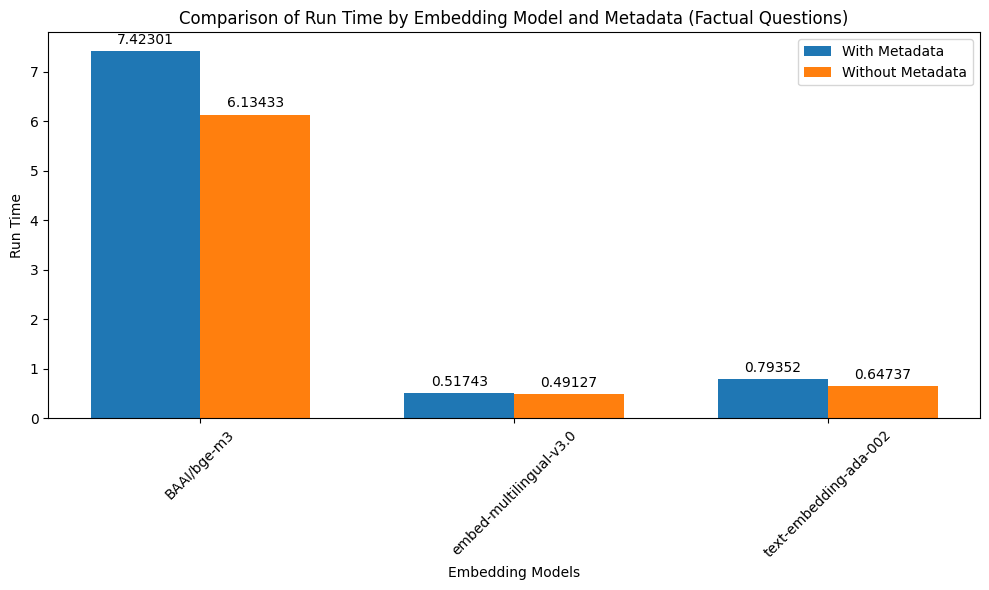

In [ ]:
grouped = final_df.groupby(['embedding_model', 'metadata']).mean().reset_index()

with_metadata = grouped[grouped['metadata'] == 'llm_metadata']
without_metadata = grouped[grouped['metadata'] == 'no_metadata']
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(grouped['embedding_model'].unique()))
width = 0.35

bars1 = ax.bar(x, with_metadata['run_time'], width, label='With Metadata')
bars2 = ax.bar([i + width for i in x], without_metadata['run_time'], width, label='Without Metadata')

ax.set_xlabel('Embedding Models')
ax.set_ylabel('Run Time')
ax.set_title('Comparison of Run Time by Embedding Model and Metadata (Factual Questions)')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(grouped['embedding_model'].unique(), rotation=45)
ax.legend()

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()

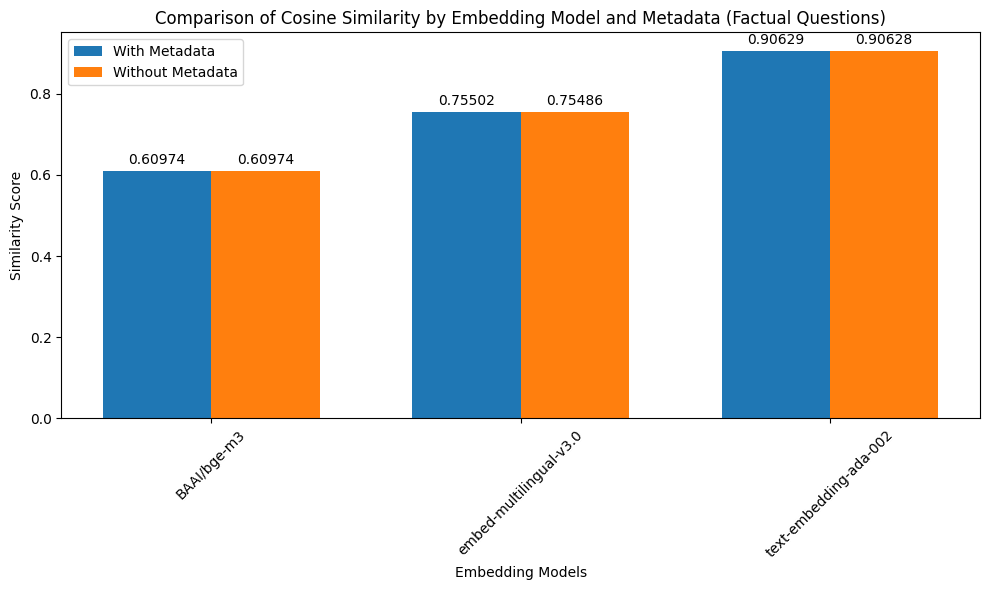

In [ ]:
grouped = final_df.groupby(['embedding_model', 'metadata']).mean().reset_index()
with_metadata = grouped[grouped['metadata'] == 'llm_metadata']
without_metadata = grouped[grouped['metadata'] == 'no_metadata']
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(grouped['embedding_model'].unique()))
width = 0.35

bars1 = ax.bar(x, with_metadata['similarity_score'], width, label='With Metadata')
bars2 = ax.bar([i + width for i in x], without_metadata['similarity_score'], width, label='Without Metadata')

ax.set_xlabel('Embedding Models')
ax.set_ylabel('Similarity Score')
ax.set_title('Comparison of Cosine Similarity by Embedding Model and Metadata (Factual Questions)')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(grouped['embedding_model'].unique(), rotation=45)
ax.legend()

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()

### With Abstract Data

In [ ]:
abstract_queries = [
    "Fiyat bilgisi istiyorum",
    "kasko yaptıracam",
    "sağlık sigortası lazım neleri önerirsin",
    "trafik sigortası yaptırmama gerek var mı",
    "kedim için sigorta yapar mısınız",
    "aracım kaza yaptı, ne kadarını karşılıyorsunuz",
    "depremde evim yıkılsa karşılıyor musunuz?",
    "kiracıyım ama ev sigortası yaptırabilir miyim?",
    "gözümde sıkıntı var sağlık sigortası bunu karşılar mı",
    "nasıl başvurabilirim?"
]

In [ ]:
metadata_optimization_results = {
    "run_time": [],
    "embedding_model": [],
    "similarity_score": [],
    "metadata": []
}

embedding_models = [
    bge_m3,
    cohere_embedding,
    ada_002
]

vectorstores = [
    loaded_faissdb_bge_nm,
    loaded_faissdb_cohere_nm,
    loaded_faissdb_openai_nm
]

for question in abstract_queries:
  for model, vectorstore in zip(embedding_models, vectorstores):
    process_begins = time.time()
    query_embeddings, retrieved_embeddings, similarity_scores = combine_embeddings(
        query=question,
        vector_store=vectorstore,
        embedding_model=model,
        number_of_documents=4,
        calculate_similarity=True
        )
    process_ends = time.time()
    metadata_optimization_results["run_time"].append(process_ends - process_begins)
    metadata_optimization_results["similarity_score"].append(similarity_scores[0])
    metadata_optimization_results["metadata"].append("no_metadata")

    try:
      metadata_optimization_results["embedding_model"].append(model.model_name)
    except:
      metadata_optimization_results["embedding_model"].append(model.model)

In [ ]:
result_without_metadata = pd.DataFrame.from_dict(metadata_optimization_results)
result_without_metadata.to_csv("abstract_result_without_metadata.csv")

In [ ]:
metadata_abstract_result = pd.read_csv("abstract_result_with_metadata.csv")
no_metadata_abstract_result = pd.read_csv("abstract_result_without_metadata.csv")
abstract_final_df = pd.concat([metadata_abstract_result, no_metadata_abstract_result], axis=0)
abstract_final_df.drop(["Unnamed: 0"], axis=1, inplace=True)
abstract_final_df.to_csv("abstract_final_result.csv")

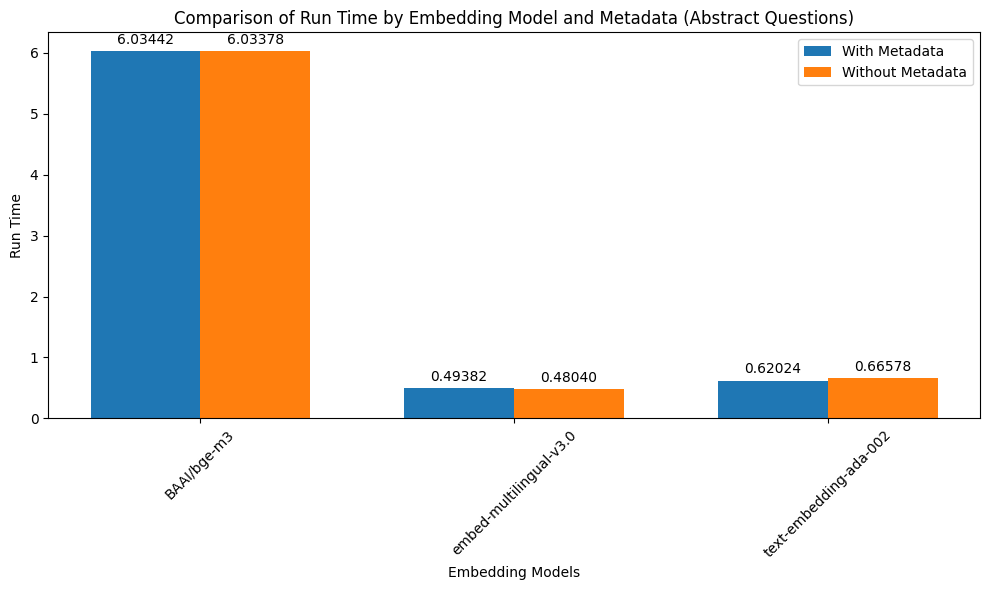

In [ ]:
grouped = abstract_final_df.groupby(['embedding_model', 'metadata']).mean().reset_index()

with_metadata = grouped[grouped['metadata'] == 'llm_metadata']
without_metadata = grouped[grouped['metadata'] == 'no_metadata']
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(grouped['embedding_model'].unique()))
width = 0.35

bars1 = ax.bar(x, with_metadata['run_time'], width, label='With Metadata')
bars2 = ax.bar([i + width for i in x], without_metadata['run_time'], width, label='Without Metadata')

ax.set_xlabel('Embedding Models')
ax.set_ylabel('Run Time')
ax.set_title('Comparison of Run Time by Embedding Model and Metadata (Abstract Questions)')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(grouped['embedding_model'].unique(), rotation=45)
ax.legend()

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()

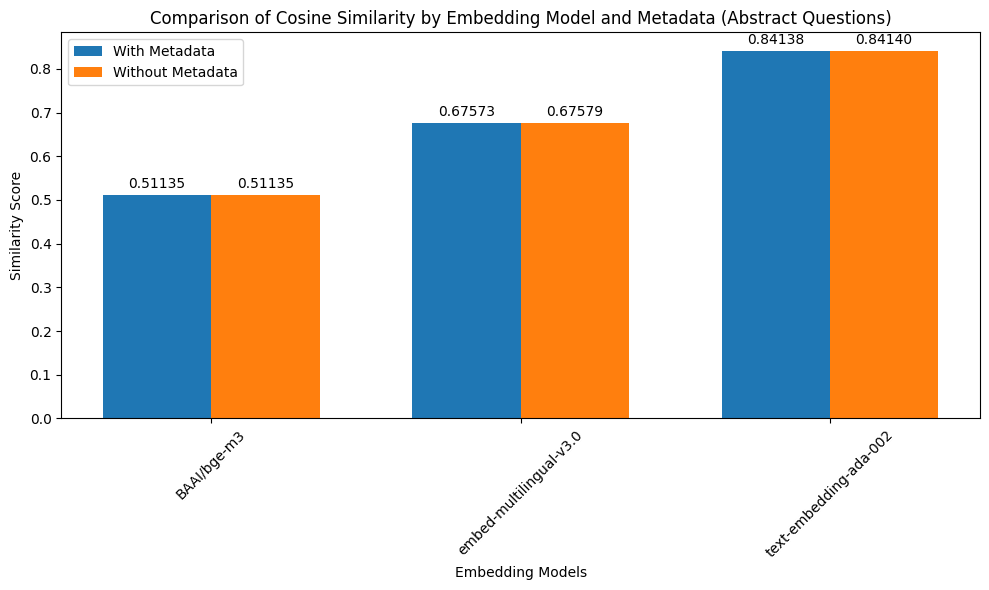

In [ ]:
grouped = abstract_final_df.groupby(['embedding_model', 'metadata']).median().reset_index()
with_metadata = grouped[grouped['metadata'] == 'llm_metadata']
without_metadata = grouped[grouped['metadata'] == 'no_metadata']
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(grouped['embedding_model'].unique()))
width = 0.35

bars1 = ax.bar(x, with_metadata['similarity_score'], width, label='With Metadata')
bars2 = ax.bar([i + width for i in x], without_metadata['similarity_score'], width, label='Without Metadata')

ax.set_xlabel('Embedding Models')
ax.set_ylabel('Similarity Score')
ax.set_title('Comparison of Cosine Similarity by Embedding Model and Metadata (Abstract Questions)')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(grouped['embedding_model'].unique(), rotation=45)
ax.legend()

annotate_bars(bars1)
annotate_bars(bars2)

plt.tight_layout()
plt.show()

## RAG Methods

In [ ]:
import langsmith
from langchain import smith
from datetime import datetime

eval_config = smith.RunEvalConfig(
    evaluators=[
        "cot_qa",
        smith.RunEvalConfig.LabeledCriteria("conciseness"),
        smith.RunEvalConfig.LabeledCriteria("relevance"),
        smith.RunEvalConfig.LabeledCriteria("coherence"),
        smith.RunEvalConfig.LabeledCriteria("helpfulness")
    ],
    custom_evaluators=[],
    eval_llm=evaluator
)


client = langsmith.Client()
chain_results = client.run_on_dataset(
    dataset_name="trustguard-rag-dataset",
    llm_or_chain_factory=stuff_rag_chain,
    evaluation=eval_config,
    project_name="Stuff Method (BGE)",
    verbose=True,
)

View the evaluation results for project 'Stuff Method (BGE)' at:
https://smith.langchain.com/o/a8a19e22-eabd-533f-b2d6-b79b0371c5b1/datasets/4ec4899c-b9b6-411b-80c0-5ae69a29dfb6/compare?selectedSessions=5ac25d37-fd2f-4842-857c-b7b8d634a01f

View all tests for Dataset trustguard-rag-dataset at:
https://smith.langchain.com/o/a8a19e22-eabd-533f-b2d6-b79b0371c5b1/datasets/4ec4899c-b9b6-411b-80c0-5ae69a29dfb6
[------------------------------------------------->] 12/12
 Experiment Results:
        feedback.COT Contextual Accuracy  feedback.conciseness  feedback.relevance  feedback.coherence  feedback.helpfulness error  execution_time                                run_id
count                              12.00                 12.00               12.00               12.00                 12.00     0           12.00                                    12
unique                               NaN                   NaN                 NaN                 NaN                   NaN     0            